## First we need to authenticate google drive account to download the dataset subset that we have previously uploaded to google drive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Now we will download and unzip the dataset

In [ ]:
folder_id = "1ZoR0Xjl3Kr134B1YcApV4yMcZZ-_dV0N"
file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
for i, file1 in enumerate(sorted(file_list, key = lambda x: x['title']), start=1):
    file1.GetContentFile(file1['title'])
!zip -q -F dataset.zip --out single_dataset.zip
!unzip -q single_dataset.zip

## Download and import the pykitti library to ease the process of deadling with the dataset


In [ ]:
!pip install -q pykitti
import pykitti

## Define the base directory of the dataset and the sequence that we want to load then create a dataset object

In [ ]:
basedir = './dataset'
sequence = '00'
dataset = pykitti.odometry(basedir, sequence)

# Lucas Kanade 

In [ ]:
def lucas_kanade(current_frame, next_frame, current_features, win_size = 3):
    """
    Lucas-Kanade optical flow algorithm for tracking features between two frames.

    :param current_frame: axb numpy matrix representing the first grayscale image.
    :param next_frame: axb numpy matrix representing the second grayscale image.
    :param current_features: (n x 2) np array containing the coordinates of features of the current frame, where n is
                            the number of features.
    :param win_size: size of window to use when calculating motion vectors

    :return: new_features: (n x 2) np array containing the new coordinates of features in the next frame, where n is
                            the number of features.
    """

    sobel_width = win_size  # size of sobel filter
    sigma = 1 # sigma of gaussian blur filter
    k_size = (win_size, win_size)  # size of gaussian blur filter

    # 1-Smooth both frames to remove noise
    cur_frame_smoothed = cv2.GaussianBlur(current_frame, k_size, sigma)
    next_frame_smoothed = cv2.GaussianBlur(next_frame, k_size, sigma)

    # 2-Compute the X, Y, and time derivatives for the current frame and next frame

    # calculate x-derivatives
    Ix_cur = cv2.Sobel(cur_frame_smoothed, cv2.CV_64F, 1, 0, ksize=sobel_width)
    Ix_next = cv2.Sobel(next_frame_smoothed, cv2.CV_64F, 1, 0, ksize=sobel_width)
    # combine and smooth the x-derivatives
    Ix = (Ix_cur + Ix_next)/2

    # calculate y-derivatives
    Iy_cur = cv2.Sobel(cur_frame_smoothed, cv2.CV_64F, 0, 1, ksize=sobel_width)
    Iy_next = cv2.Sobel(next_frame_smoothed, cv2.CV_64F, 0, 1, ksize=sobel_width)
    # combine and smooth the y-derivatives
    Iy = (Iy_cur + Iy_next)/2
    
    # Compute the time-derivative It
    It = cur_frame_smoothed - next_frame_smoothed


    # 3-Calculate motion vectors u, v for for all features
  
    half_win = win_size // 2  # define the length of half window
    # initialize the nx2 numpy matrix which will store the new features
    new_features = np.zeros((current_features.shape[0], current_features.shape[1]))
    for i in range(current_features.shape[0]):  # loop on all features

        # The coordinates of the each feature
        cur_coord_feature_y = current_features[i, 0]
        cur_coord_feature_x = current_features[i, 1]

        # extract a window of Ix around the current feature location
        Ix_win = Ix[cur_coord_feature_x - half_win: cur_coord_feature_x + half_win + 1,
                    cur_coord_feature_y - half_win: cur_coord_feature_y + half_win + 1]

        # extract a window of Iy around the current feature location
        Iy_win = Iy[cur_coord_feature_x - half_win: cur_coord_feature_x + half_win + 1,
                    cur_coord_feature_y - half_win: cur_coord_feature_y + half_win + 1]

        # extract a window of It around the current feature location
        It_win = It[cur_coord_feature_x - half_win: cur_coord_feature_x + half_win + 1,
                    cur_coord_feature_y - half_win: cur_coord_feature_y + half_win + 1]

        # 4-Now we want to put the problem in the form of Ax=b to find x using least squares

        # matrix A is the matrix [Ix, Iy] where Ix/Iy are column vectors containing
        # the values of Ix and Iy in the window
        A = np.concatenate((Ix_win.reshape(-1, 1), Iy_win.reshape(-1, 1)), axis=1)
        
        # b is a column vector containing [-It] where It is the values of It in the window
        b = -1*It_win.reshape(-1, 1)
        # use least squares to find x from A and b
        x = np.linalg.lstsq(A, b)[0]

        # the new location of the current feature is its original location plus the motion vectors
        new_features[i, :] = current_features[i, :] + np.array(x).transpose()

    # cast the coordinates to int before returning them
    return np.int32(new_features)


# Pose Estimation

In [ ]:
#!/usr/bin/env python
# coding: utf-8


import numpy as np
def _singularize(F):
    """
    Takes an NxN Matrix F and make it rank-2 be making the lowest eigen value equals to zero  
    """
    U, S, V = np.linalg.svd(F)
    S[-1] = 0 # Make the lowest Eignvalue = 0
    F = U @ np.diag(S) @ V # Returning the Matrix again
    return F

def eightpoint(pts1, pts2, M):
    """
    Takes Two lists of corresponding points pts1 and pts 2 and 
    """
    pts1_scaled = pts1/M # scaling the points for numerical stability
    pts2_scaled = pts2/M # scaling the points for numerical stability

    A_f = np.zeros((pts1_scaled.shape[0], 9))

    for i in range(pts1_scaled.shape[0]): # Constructing the A matrix to be minimized 
        A_f[i, :] = [ pts2_scaled[i,0]*pts1_scaled[i,0] , pts2_scaled[i,0]*pts1_scaled[i,1] , pts2_scaled[i,0], pts2_scaled[i,1]*pts1_scaled[i,0] , pts2_scaled[i,1]*pts1_scaled[i,1] , pts2_scaled[i,1], pts1_scaled[i,0], pts1_scaled[i,1], 1  ]

    # Using SVD to solve the minimization problem
    u, s, vh = np.linalg.svd(A_f)
    v = vh.T

    # f is the fundamental matrix to reshapeing it for furthure processing 
    f = v[:, -1].reshape(3,3)

    f = _singularize(f) # Making the matrix Singular 

    T =  np.diag([1/M,1/M,1]) # Rescaling it to the correct Scale 

    return T.T.dot(f).dot(T) # return rescaled version of the fundamental matrix  

def essentialMatrix(F, K1, K2):
    """
    Recover the essentional matrix from the fundamental Matrix using K1, K2 (the two camera intrensic parameters, they are the same 
    in this project as we use the same camera at different shots while moving)
    """
    E = K2.T.dot(F).dot(K1)
    return E




def ransac_fundamental_matrix(matches_a, matches_b,M,threshold=3,itr=500):
    """
    Run the ransac algorithm to the 8-point algorithm
    """"
    best_F = eightpoint(matches_a[:20, :], matches_b[:20, :],M) # initial random estimate to create memory 
    inliers_a = matches_a 
    inliers_b = matches_b

    best_num_inliers = 0 # initial inliers 
    for i in range(0, itr):

        # sample a random 10 values of the points
        index = np.random.choice(len(matches_a), 10,replace=False) # Sampling the index 
        rand_a = matches_a[index] # using the index to get the random points 
        rand_b = matches_b[index] # using the index to get the corresponding random points 


        F_matrix = eightpoint(rand_a, rand_b,M) # Estimate the fundamental matrix
        
        inliers_a_temp = []
        inliers_b_temp = []
        
        total_inliers = 0
        
        for j in range (0, matches_a.shape[0]): # Calculating the total number of inliers in for the current Fandamental matrix

            b_temp = np.append(matches_b[j,:],1)
            a_temp = np.append(matches_a[j,:],1)
            error = b_temp.T @ F_matrix @ a_temp # it should ideally be zero but in case of error it would be  
            if np.abs(error) < threshold: # if a point is an inleir add it to the inlier list 
                inliers_a_temp.append(matches_a[j,:])
                inliers_b_temp.append(matches_b[j,:])
                total_inliers += 1
            if total_inliers > best_num_inliers: # if a minimum error take it as the new best fundamental matrix 
                best_num_inliers = total_inliers
                inliers_a = np.asarray(inliers_a_temp)
                inliers_b = np.asarray(inliers_b_temp)
                best_F = np.asarray(F_matrix)
    inliers_a = np.asarray(inliers_a)
    inliers_b = np.asarray(inliers_b)
    return best_F, inliers_a, inliers_b


def robost(matches_a, matches_b):
    """A function for the ransac to use the Built-in OpenCV configuration """
    F,mask = cv2.findFundamentalMat(matches_a, matches_b,cv2.FM_RANSAC,0.3,0.9)
    inliers_a=[]
    inliers_b=[]
    
    for index,x in enumerate(mask):
      if x:
        inliers_a.append(matches_a[index])
        inliers_b.append(matches_b[index])
    return F,np.array(inliers_a),np.array( inliers_b)


    
def decomposeEssentialMatrix(E):
    """ Recovering the rotation and traslation matrices from the Essential matrix """"
    
    # Making the essential matrix singular and have 2 identical eigen values  
    U, D, V = np.linalg.svd(E)
    e = (D[0] + D[1]) / 2
    D[0] = e
    D[1] = e
    D[2] = 0
    E = U @ np.diag(D) @ V



    U, D, V = np.linalg.svd(E)

    W =np.array( [[0 ,-1 ,0] ,[1, 0 ,0], [0 ,0 ,1]])
    Z = W.T

    # Possible rotation matrices
    R1 = U @ W @ V
    R2 = U @ W.T @ V

    if np.linalg.det (R1) < 0:
        R1 = -R1
    
    if np.linalg.det(R2) < 0:
        R2 = -R2
    

    # Translation vector
    Tx = U @ Z @ U.T
    t = np.array([Tx[2, 1], Tx[0, 2], Tx[1, 0]]);

    Rs =[ R1, R1, R2, R2]
    Ts = [t, -t, t, -t]
    return Rs, Ts

def find_rotation_trans(matches_a, matches_b,M,inliers_threshold,K1, K2,Robost = True):
    
    if not Robost : # using unoptimized algorithm 
      F,inliers_a, inliers_b=ransac_fundamental_matrix(matches_a, matches_b,M)
    else: # usign the optimized algorithm
      F,inliers_a,inliers_b=robost(matches_a, matches_b)
    if inliers_a.shape[0]<inliers_threshold: # return none if the number of inliers is less than the thershold
      return None 

    E= essentialMatrix(F, K1, K2) # get the essential matrix 
    Rs,Ts = decomposeEssentialMatrix(E) # get the poses form the essential matrix

    return (Rs, Ts ,np.array(inliers_a),np.array( inliers_b))

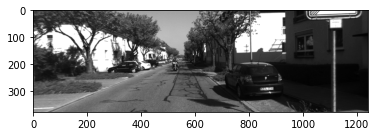

In [ ]:
import numpy as np
# for frame in dataset.cam1:  # load an image from first camera
img = (next(dataset.cam1))  # convert image to numpy array
# now do something with the image
plt.imshow(img,cmap="gray")

In [ ]:
all_frames = list(dataset.cam1)


In [ ]:
# Main: 
import cv2
Rotation =[0]

# obtain the calibration matrix of camera 1
K=dataset.calib.K_cam1

# get the first frame from the dataset
f0 = np.array(all_frames[0])
# get the second frame from the dataset
f1 = np.array(all_frames[1])

M= np.max(f1.shape)

base_threshold=70

inliers_threshold=base_threshold

i= 2

# set the parameters of feature extraction
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 3,
                       blockSize = 3 )

# extract features in the key frame
matches_a= cv2.goodFeaturesToTrack(f0, mask = None, **feature_params)

flag= False # this flag will be used to toggle adaptive threshold on/off
while i < 150: # only take the first 150 frames
  # reshape features to nx2
  matches_a = matches_a.reshape(-1, 2)
  # make sure all coordinates are integers
  matches_a = np.int32(matches_a)
  # track features from frame f0 to frame f1 using Lucas Kanade
  matches_b, st, err  = lucas_kanade(f0, f1, matches_a)
  print(i)

  # fint rotation and translation matrix using correspondces between f0 and f1
  condition =find_rotation_trans(matches_a, matches_b,M,inliers_threshold,K, K)

  if condition ==None:  # if output is None => high number of ouliers
    if flag:  # if adaptive flag is on then relax the outlier threshold
       inliers_threshold-=5
    # if the adaptive flag is off then turn it on
    flag = True
    print ("Hi")
    # extract new features from f0
    matches_a= cv2.goodFeaturesToTrack(f0, mask = None, **feature_params)
    # restart
    continue

  if not flag:  # if adaptive flag is off then make the threshold more strict
    inliers_threshold=inliers_threshold+5
  flag= False
  
  if (inliers_threshold>= base_threshold): # ensuring that the inliers_threshold do not exceed the base threshold 
    inliers_threshold= base_threshold 

  Rs, Ts ,inliers_a, inliers_b  = condition 
  print(matches_a.shape , inliers_a.shape)
  # Rs -> General rotation 

  # Since There are two rotation Matrices Rs[0], Rs[1], Rs[2], Rs[3] where Rs[0]=Rs[1] and Rs[2]=Rs[3]
  # We have to choose between only one of them, The one with the positve trase so that it will be infront of the camera not behind it
  if Rs[0][0,0]+Rs[0][1,1]+Rs[0][1,1] > 1.5: # Check strong positivity (ideally must equal to 3 but 1.5 to account for the errors)
    Ry=Rs[0][2,0] #We are intersed only in the rotation across the y axis (The car is not gonna fly nor flip , hopefully :"D )
  else:  
    Ry=Rs[2][2,0]
  print ("Truth ",dataset.poses[i][0,2]/np.pi*180) # For debuging 
  if i!=2: # ignoring the first  frame as it severly errorous 
    Rotation.append(Rotation[-1]+np.arcsin(round(Ry, 4)))
 
  print ("estimated ",Rotation[-1]/np.pi*180)# For debuging
 
 
  inliers_b=inliers_b.reshape((inliers_b.shape[0], 1, 2)) # reshaping the output to the correct shape for lucus-canadi method 
  inliers_b = inliers_b.astype(np.float32)
  # feature coordinates for the next iteration are the inliers coordinates
  matches_a= inliers_b
  # progress the frames by 1
  f0=f1
  f1= np.array(all_frames[i])
  i=i+1

2
Hi
2
Hi
2
Hi
2
Hi
2
Hi
2
Hi
2
(100, 2) (47, 2)
Truth  -0.23670880409981362
estimated  0.0
3
Hi
3
(100, 2) (47, 2)
Truth  -0.35515195731218624
estimated  -0.21772448614212
4
Hi
4
Hi
4
Hi
4
(100, 2) (35, 2)
Truth  -0.4734635594147967
estimated  -0.5672309087171052
5
Hi
5
(100, 2) (41, 2)
Truth  -0.5919192604028827
estimated  -0.8136035198656
6
Hi
6
(100, 2) (35, 2)
Truth  -0.7102379098863734
estimated  -1.0714353978620514
7
Hi
7
(100, 2) (35, 2)
Truth  -0.8287169875525007
estimated  -1.7246214328417004
8
Hi
8
(100, 2) (38, 2)
Truth  -0.9470493880230744
estimated  -1.97672367615363
9
Hi
9
(100, 2) (35, 2)
Truth  -1.0655021096306256
estimated  -2.257474119245066
10
Hi
10
Hi
10
(100, 2) (32, 2)
Truth  -1.1839960841994264
estimated  -1.3177812087191827
11
Hi
11
(100, 2) (43, 2)
Truth  -1.302288377624341
estimated  -1.1172455709950464
12
Hi
12
(100, 2) (46, 2)
Truth  -1.4207588609235413
estimated  -0.7104421185763382
13
Hi
13
(100, 2) (49, 2)
Truth  -1.5392167391512486
estimated  -1.0370298

# Ploting the Results

In [ ]:
current_location= [np.array([0,0])]
current_angle= np.array([0,0])
for i in range(len(all_frames)-3): # using the rotation with the truth value scales to produce the Estimated Trajectory
  current_location.append(current_location[-1]+np.sqrt(np.sum((dataset.poses[1][0:3,3])**2))*np.array([np.sin(Rotation[i]/180*np.pi),np.cos(Rotation[i]/180*np.pi)]))



In [ ]:
current_location=np.array(current_location)
current_location

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  8.60442887e-01],
       [-5.70668707e-05,  1.72088577e+00],
       ...,
       [-3.85305481e+02,  3.88000457e+03],
       [-3.85456172e+02,  3.88085172e+03],
       [-3.85606866e+02,  3.88169886e+03]])

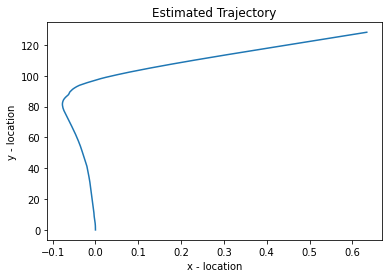

In [ ]:
# Estimated Locations
plt.plot( current_location[:150,0], current_location[:150,1])
  
# naming the x axis
plt.xlabel('x - location')
# naming the y axis
plt.ylabel('y - location')
  
# giving a title to my graph
plt.title('Estimated Trajectory')
  
# function to show the plot
plt.show()

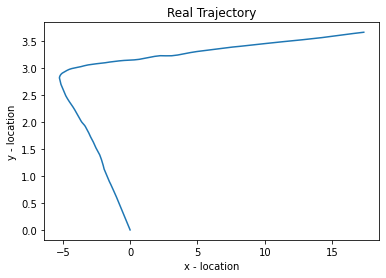

In [ ]:
# Finding True locations from the data set 
current_real_location= [np.array([0,0])]
for i in range(1,len(all_frames)-3):
  current_real_location.append ([dataset.poses[i][0,3],dataset.poses[i][1,3]])
current_real_location=np.array(current_real_location)
# True Locations
plt.plot( current_real_location[:150,0],- current_real_location[:150,1])
  
# naming the x axis
plt.xlabel('x - location')
# naming the y axis
plt.ylabel('y - location')
  
# giving a title to my graph
plt.title('Real Trajectory')
  
# function to show the plot
plt.show()